# Эксперимент по модернизации данных 2

**Суть эксперимента в следующем: мы берем нашу лучшую модель из Neural net without uncertain. То есть обученную без учета папки "Uncertain", где нет одной ярко выраженной эмоции, чтобы минимизировать дезинформацию сети. Далее прогоняем каждую фотографию исходного датасета через эту сеть и предсказываем для нее эмоцию, а также её процент вероятности, т.е. насколько сеть в ней уверена. Дополняем исходный датафрейм столбцами predict_emotion, predict_percent и real_percent. Причем если вероятность эмоции меньше порога, который мы берем на основании лучшего результата на kaggle равным 0.2, то мы записываем в столбец предсказанной эмоции uncertain и предсказанную вероятность - 1. Сохраняем полученный датафрейм для дальнейшего использования во внешний файл df.txt. Далее скриптом на основании этого датафрейма и предсказанных эмоций создаем новые папки predict_anger, predict_contempt и т.д. Файлы в этих папках имеют название типа anger123.jpg, что значит что изначально в исходных данных эмоция была определена как anger и шла под номером 123. Сейчас она может быть в другой папке, например predict_sad, что значит - сеть предсказала, что данная эмоция не anger, а sad. Теперь вручную мы проверяем каждую папку с предсказаниями и визуально видим качество определения эмоций сетью. Фото, имеющие исходную эмоцию, отличную от предсказанной, перемещаем в исходную папку, соответствующую предсказанию, то есть из примера выше anger123 переместим в папку sad. Это если мы согласны с предсказанием сети. Если нет - то перемещаем это фото в папку с той эмоцией, которую мы определили визуально. Давайте пока запишем этот код.**

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from livelossplot.tf_keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
import time
import numpy as np
from PIL import Image
import glob
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
# !pip install livelossplot
# !pip install tensorflow-addons

In [7]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Скиллбокс/Нейронные сети/Дипломная работа

Mounted at /content/drive
/content/drive/MyDrive/Скиллбокс/Нейронные сети/Дипломная работа


**Считываем исходный датафрейм**

In [8]:
df = pd.read_csv('train.csv', index_col = 0)
df['image_path'] = df['image_path'].apply(lambda x: os.path.join(*x.split(sep = '/')))
df

image_path    emotion
0            ./train/anger/0.jpg      anger
1            ./train/anger/1.jpg      anger
2           ./train/anger/10.jpg      anger
3          ./train/anger/100.jpg      anger
4         ./train/anger/1000.jpg      anger
...                          ...        ...
50041  ./train/uncertain/995.jpg  uncertain
50042  ./train/uncertain/996.jpg  uncertain
50043  ./train/uncertain/997.jpg  uncertain
50044  ./train/uncertain/998.jpg  uncertain
50045  ./train/uncertain/999.jpg  uncertain

[50046 rows x 2 columns]

**Для удобства работы нижезаписанной функции создадим словарь-перевертыш с ключами - эмоциями.**

In [9]:
names = {0: "anger", 1: "contempt", 2: "disgust", 3: "fear",
             4: "happy", 5: "neutral", 6: "sad", 7: "surprise", 8: "uncertain"}
names_reverse = {v : str(k) for k, v in names.items()}

**Эта функция применяется к каждой строке исходного датафрейма, предсказывает эмоцию, ее вероятность и вероятность эмоции, изначально переданной нам в исходных данных.**

In [10]:
def one_emotion_predict(model, path, img_size, norm = False, emo_key = 0, threshold = 0.5):
    test_img = Image.open(path)
    test_img = test_img.resize((img_size, img_size))
    test_img = np.array(test_img.getdata()).reshape(test_img.size[0], test_img.size[1], 3)
    if norm:
        test_img = test_img / 255
    test_img = test_img[np.newaxis, ...]
    pred = model.predict(test_img)[0]
    if max(pred) < threshold:
        if emo_key == 8:
            return 8, 1, 1
        else:
            return 8, 1, pred[emo_key]
    else:
        if emo_key == 8:
            return np.argmax(pred), max(pred), 1
        else:
            return np.argmax(pred), max(pred), pred[emo_key]

In [11]:
IMAGE_SIZE = 224

**Загружаем модель с наилучшим результатом на kaggle.**

In [ ]:
transf_learn_model = load_model(os.path.join(os.getcwd(),'CPT', 'transf_learn_model_without_uncertain', '12_checkpoint_0.501'))

2023-04-27 08:17:46.139154: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 08:17:46.569181: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5802 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:05:00.0, compute capability: 8.6


**Далее создаем вышеописанный датафрейм. Поясню принцип его создания - за один проход у меня его создать не получилось. Память переполнялась. Поэтому я разделил его на пять частей по 10000 строк в каждой. Каждую часть преобразовал, сохранил во внешних файлах df_1.txt, df_2.txt и т.д. Далее загрузил их все и склеил в один датафрейм, который уже финишно сохранил во внешний файл df.txt.**

In [ ]:
df_part = df.iloc[40000:,]

In [ ]:
df_part['emotion_number'] = df_part['emotion'].apply(lambda x: names_reverse[x])
df_part['path + number'] = df_part['image_path'] + df_part['emotion_number']
df_part['predict_emotion'] = df_part['image_path'].apply(lambda x: one_emotion_predict(transf_learn_model, x, IMAGE_SIZE,
                                                                                 threshold = 0.2)[0])
df_part['predict_emotion'] = df_part['predict_emotion'].apply(lambda x: names[x])
df_part['predict_percent'] = df_part['image_path'].apply(lambda x: one_emotion_predict(transf_learn_model, x, IMAGE_SIZE,
                                                                                 threshold = 0.2)[1])
df_part['real_percent'] = df_part['path + number'].apply(lambda x: one_emotion_predict(transf_learn_model, x[:-1], IMAGE_SIZE,
                                                                                 emo_key = int(x[-1]), threshold = 0.2)[2])
df_part = df_part[['image_path', 'emotion', 'predict_emotion', 'predict_percent', 'real_percent']]

1/1 [==============================] - 0s 56ms/step


/tmp/ipykernel_407989/3682238635.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5['emotion_number'] = df_5['emotion'].apply(lambda x: names_reverse[x])
/tmp/ipykernel_407989/3682238635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5['path + number'] = df_5['image_path'] + df_5['emotion_number']


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 56ms/step


/tmp/ipykernel_407989/3682238635.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5['predict_emotion'] = df_5['image_path'].apply(lambda x: one_emotion_predict(transf_learn_model, x, IMAGE_SIZE,
/tmp/ipykernel_407989/3682238635.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5['predict_emotion'] = df_5['predict_emotion'].apply(lambda x: names[x])


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_407989/3682238635.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5['predict_percent'] = df_5['image_path'].apply(lambda x: one_emotion_predict(transf_learn_model, x, IMAGE_SIZE,


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 54ms/step


/tmp/ipykernel_407989/3682238635.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5['real_percent'] = df_5['path + number'].apply(lambda x: one_emotion_predict(transf_learn_model, x[:-1], IMAGE_SIZE,


In [ ]:
with open("df_5.txt", "wb") as myFile: # Здесь по очереди меняем индексы для сохранения df_1, df_2 и т.д.
    pickle.dump(df_5, myFile)

In [ ]:
with open("df_1.txt", "rb") as myFile:
    df_1 = pickle.load(myFile)
with open("df_2.txt", "rb") as myFile:
    df_2 = pickle.load(myFile)
with open("df_3.txt", "rb") as myFile:
    df_3 = pickle.load(myFile)
with open("df_4.txt", "rb") as myFile:
    df_4 = pickle.load(myFile)

In [ ]:
df = pd.concat([df_1, df_2, df_3, df_4, df_5])
df.describe()

predict_percent  real_percent
count     50046.000000  50046.000000
mean          0.556177      0.497694
std           0.199526      0.324408
min           0.200456      0.000086
25%           0.396321      0.207673
50%           0.521065      0.454696
75%           0.698116      0.791345
max           1.000000      1.000000

In [ ]:
# with open("df.txt", "wb") as myFile:
#     pickle.dump(df, myFile)
with open("df.txt", "rb") as myFile:
    df = pd.read_pickle(myFile)

In [ ]:
df['image_path'] = df['image_path'].apply(lambda x: os.path.join('.', 'train_2', *x.split('/')[-2:]))
df

image_path    emotion predict_emotion  \
0            ./train_2/anger/0.jpg      anger            fear   
1            ./train_2/anger/1.jpg      anger         neutral   
2           ./train_2/anger/10.jpg      anger           anger   
3          ./train_2/anger/100.jpg      anger           anger   
4         ./train_2/anger/1000.jpg      anger         neutral   
...                            ...        ...             ...   
50041  ./train_2/uncertain/995.jpg  uncertain        surprise   
50042  ./train_2/uncertain/996.jpg  uncertain         neutral   
50043  ./train_2/uncertain/997.jpg  uncertain             sad   
50044  ./train_2/uncertain/998.jpg  uncertain             sad   
50045  ./train_2/uncertain/999.jpg  uncertain             sad   

       predict_percent  real_percent  
0             0.642120      0.341115  
1             0.931658      0.014904  
2             0.610033      0.610033  
3             0.489100      0.489100  
4             0.574323      0.153754  
...                ...           ...  
50041         0.340830      1.000000  
50042         0.574608      1.000000  
50043         0.968403      1.000000  
50044         0.560965      1.000000  
50045         0.495328      1.000000  

[50046 rows x 5 columns]

**Создаем и заполняем новые папки с предсказаниями.**

In [ ]:
for emo in names.values():
    df_emo = df[df['predict_emotion'] == emo]
    for i in range(len(df_emo)):
        img = Image.open(df_emo.iloc[i, 0])
        imgpath = os.path.join('.', 'train_2', 'predict_' + emo)
        if not os.path.exists(imgpath):
            !mkdir -p {imgpath}
        img.save(os.path.join(imgpath, df_emo.iloc[i, 0].split(os.sep)[-2] + df_emo.iloc[i, 0].split(os.sep)[-1]))

**Для того, чтобы понять, насколько повлияет правильное расположение эмоций, т.е. очистка от шума, которую мы сейчас производим, на результат на kaggle, достаточно сделать это для достаточно весомой доли исходных фото. Моего терпения хватило на разбор 10000 фотографий, т.е. 1/5 от исходного количества. Далее подготавливаем новые данные для обучения. Фотографии в исходном датасете в папках эмоций расположены под номерами, идущими последовательно от 0 и далее через единицу. 0.jpg - 1.jpg - 2.jpg и т.д. Создадим словарь, в котором для каждой эмоции запишем номер последней фотографии в папке.**

In [ ]:
idxs = {
    'anger': len(df[df['emotion'] == 'anger']),
    'contempt': len(df[df['emotion'] == 'contempt']),
    'disgust': len(df[df['emotion'] == 'disgust']),
    'fear': len(df[df['emotion'] == 'fear']),
    'happy': len(df[df['emotion'] == 'happy']),
    'neutral': len(df[df['emotion'] == 'neutral']),
    'sad': len(df[df['emotion'] == 'sad']),
    'surprise': len(df[df['emotion'] == 'surprise']),
    'uncertain': len(df[df['emotion'] == 'uncertain'])
}

**Поясним, что делает следующий скрипт. Мы идем по папкам с эмоциями. Напомним их структуру после нашей сортировки - в них находятся исходные фотографии по порядку номеров от 0 до максимального номера, записанного в словаре idxs под соответствующим ключом, а также фотографии, помещенные в каждую папку нами с правильной, соответствующей данной папке эмоцией, но изначально находившиеся в папке с несоответствующей эмоцией. Они имеют название типа <эмоция><исходный нномер>.jpg. Далее идем по всем фото в папке и как только скрипт натыкается на фото с данной структурой номера он берет эту фото в исходной папке (опираясь на эмоцию из названия фото) и удаляет ее из исходной папки (опираясь на номер из названия фото). После чего сохраняет ее в текущей папке присваивая ей номер, следующий по порядку после максимального текущего.**

In [ ]:
for emo in names.values():
    print(f'Сканируем папку {emo}')
    print(100 * '_')
    img_list = glob.glob("./train_2/" + emo + "/*.jpg")
    for img in img_list:
        compound_name = img.split('/')[-1]
        folder = ''
        while compound_name[0].isalpha():
            folder += compound_name[0]
            compound_name = compound_name[1:]
        if folder != '':
            print(f'Нашли фотку из папки {folder} под номером {compound_name}')
            df = df[df['image_path'] != './train_2/' + folder + '/' + compound_name]
            print(f'Датасет стал длиной {len(df)}')
            os.remove('./train_2/' + folder + '/' + compound_name)
            new_name = './train_2/' + emo + '/' + str(idxs[emo]) + '.jpg'
            print(f'Новое имя фотки {new_name}')
            new_row = pd.DataFrame({'image_path': new_name, 'emotion': emo})
            df = pd.concat([df, new_row], ignore_index = True)
            print(f'Датасет стал опять длиной {len(df)}')
            idxs[emo] += 1
            new_img = Image.open(img)
            new_img.save(new_name)
            os.remove(img)

Сканируем папку anger
____________________________________________________________________________________________________
Нашли фотку из папки fear под номером 1986.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/anger/7022.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 2753.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/anger/7023.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 386.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/anger/7024.jpg
Датасет стал опять длиной 50046
Сканируем папку contempt
____________________________________________________________________________________________________
Нашли фотку из папки surprise под номером 5160.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/contempt/3085.jpg
Датасет стал опять длиной 50046
Сканируем папку disgust
____________________________________________________________________________________________________
Нашли фотку из папки anger под номер

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Сканируем папку happy
____________________________________________________________________________________________________
Нашли фотку из папки surprise под номером 1034.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/5955.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 5274.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/5956.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки contempt под номером 980.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/5957.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 1541.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/5958.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 1748.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/5959.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 2581.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/5960.jpg
Датасет ст

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Нашли фотку из папки surprise под номером 5640.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/5978.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 3906.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/5979.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 623.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/5980.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки uncertain под номером 2105.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/5981.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 3242.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/5982.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 5501.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/5983.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки uncertain под номером 4850.jpg
Датасет стал длиной 50045
Новое имя фотки ./trai

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/6011.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 4413.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/6012.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 910.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/6013.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки contempt под номером 1757.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/6014.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 3212.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/6015.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки uncertain под номером 1009.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/6016.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 3873.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/6017.jpg
Датасет стал опять длиной 50046
Н

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Новое имя фотки ./train_2/happy/6040.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 778.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/6041.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 3231.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/6042.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 4756.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/happy/6043.jpg
Датасет стал опять длиной 50046
Сканируем папку neutral
____________________________________________________________________________________________________
Нашли фотку из папки surprise под номером 2521.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6795.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 4881.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6796.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 6534.jpg
Д

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6825.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 5548.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6826.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 3141.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6827.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 676.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6828.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки sad под номером 3420.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6829.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки sad под номером 4420.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6830.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 3571.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6831.jpg
Датасет стал опять длиной 50046
Нашли фот

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6854.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 4882.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6855.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 2884.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6856.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 2003.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6857.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 6554.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6858.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки contempt под номером 1338.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6859.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 2119.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6860.jpg
Датасет стал опять длиной 500

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Новое имя фотки ./train_2/neutral/6883.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки happy под номером 4344.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6884.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 527.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6885.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки contempt под номером 1531.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6886.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 5139.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6887.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 1631.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6888.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки uncertain под номером 3150.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6889.jpg
Датасет стал опять длиной 50046
Нашли фотку из папк

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6915.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 582.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6916.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 2181.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6917.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 4727.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6918.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки sad под номером 6381.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6919.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 4894.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6920.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 6259.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6921.jpg
Датасет стал опять длиной 50046
На

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6945.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 4322.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6946.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 4369.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6947.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 3482.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6948.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 2333.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6949.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 4243.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6950.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 3414.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6951.jpg
Датасет стал опять длиной 50046


/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6977.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 5176.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6978.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки sad под номером 5809.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6979.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 3827.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6980.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 4176.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6981.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки happy под номером 5808.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6982.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 1512.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/6983.jpg
Датасет стал опять длиной 50046
Н

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7010.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки uncertain под номером 4788.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7011.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 3410.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7012.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 5919.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7013.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки sad под номером 6695.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7014.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 4801.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7015.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 5347.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7016.jpg
Датасет стал опять длиной 50046


/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7042.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 3026.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7043.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки sad под номером 4242.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7044.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 6223.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7045.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 4459.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7046.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 2078.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7047.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 1740.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7048.jpg
Датасет стал опять длиной 50046
Нашли фо

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7076.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки uncertain под номером 5003.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7077.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 3055.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7078.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки uncertain под номером 1458.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7079.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 4465.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7080.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 1356.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7081.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки uncertain под номером 1450.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/neutral/7082.jpg
Датасет стал опять дли

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Датасет стал длиной 50045
Новое имя фотки ./train_2/surprise/6323.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 2425.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/surprise/6324.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 406.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/surprise/6325.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 5483.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/surprise/6326.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 1233.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/surprise/6327.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 2708.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/surprise/6328.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 794.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/surprise/6329.jpg
Датасет стал опять длиной 50046
Н

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Нашли фотку из папки anger под номером 2616.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/5933.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 5065.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/5934.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки disgust под номером 2011.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/5935.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 4175.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/5936.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 3315.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/5937.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 1652.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/5938.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки disgust под номером 1275.jpg
Датасет стал длиной 50045
Новое имя фотк

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/5962.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 1778.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/5963.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки sad под номером 3447.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/5964.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 4332.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/5965.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки uncertain под номером 160.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/5966.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 5438.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/5967.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 5624.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/5968.jpg
Датасет ст

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Нашли фотку из папки uncertain под номером 123.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/5994.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 4391.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/5995.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 142.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/5996.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 2559.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/5997.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 361.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/5998.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 1103.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/5999.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 6017.jpg
Датасет стал длиной 50045
Новое им

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Нашли фотку из папки surprise под номером 3401.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6015.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 2846.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6016.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 5073.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6017.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 966.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6018.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 2516.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6019.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 868.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6020.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 3541.jpg
Датасет стал длиной 50045
Новое имя фо

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Нашли фотку из папки anger под номером 2589.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6053.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 3695.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6054.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки disgust под номером 656.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6055.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 4984.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6056.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки disgust под номером 2359.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6057.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 5419.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6058.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 575.jpg
Датасет стал длиной 50045
Новое 

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Нашли фотку из папки anger под номером 4659.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6068.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 899.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6069.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 4174.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6070.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 3319.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6071.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 1485.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6072.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 4453.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6073.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 843.jpg
Датасет стал длиной 50045
Новое имя фотки ./

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Нашли фотку из папки sad под номером 6655.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6095.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 3638.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6096.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 5727.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6097.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 4811.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6098.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 968.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6099.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки anger под номером 5756.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6100.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 4700.jpg
Датасет стал длиной 50045
Новое им

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6128.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки sad под номером 6585.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6129.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 1214.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6130.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки happy под номером 3479.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6131.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 1339.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6132.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 4197.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6133.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 1772.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6134.jpg
Датасет стал опять длиной

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Нашли фотку из папки surprise под номером 3737.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6157.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 5830.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6158.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 5153.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6159.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 2978.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6160.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки sad под номером 4627.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6161.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки surprise под номером 6075.jpg
Датасет стал длиной 50045
Новое имя фотки ./train_2/uncertain/6162.jpg
Датасет стал опять длиной 50046
Нашли фотку из папки fear под номером 4905.jpg
Датасет стал длиной 50045
Новое им

/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index = True)
/tmp/ipykernel_67182/1431210606.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

**Всё - наш новый датасет для обучения, более правильно разобранный по эмоциям, готов. Давайте обучим на нем сеть.**

In [12]:
# with open("df_ordered.txt", "wb") as myFile:
#     pickle.dump(df, myFile)
with open("df_ordered.txt", "rb") as myFile:
    df = pd.read_pickle(myFile)

In [ ]:
df

image_path    emotion
0          ./train_2/anger/4450.jpg      anger
1          ./train_2/anger/5895.jpg      anger
2          ./train_2/anger/5583.jpg      anger
3            ./train_2/anger/93.jpg      anger
4          ./train_2/anger/6762.jpg      anger
...                             ...        ...
50042   ./train_2/uncertain/211.jpg  uncertain
50043  ./train_2/uncertain/7197.jpg  uncertain
50044   ./train_2/uncertain/520.jpg  uncertain
50045  ./train_2/uncertain/1929.jpg  uncertain
50046  ./train_2/uncertain/7645.jpg  uncertain

[50047 rows x 2 columns]

In [ ]:
train_df = df.groupby('emotion', group_keys= False).apply(lambda x: x. sample (frac = 0.8, random_state=17))
val_df = df.drop(train_df.index)

In [21]:
photos_list = []
for i in range(5000):
    photos_list.append(os.path.join('.', 'test_kaggle', str(i) + '.jpg'))
test_df = pd.DataFrame(photos_list, columns = ['image_path'])
test_df.head()

image_path
0  ./test_kaggle/0.jpg
1  ./test_kaggle/1.jpg
2  ./test_kaggle/2.jpg
3  ./test_kaggle/3.jpg
4  ./test_kaggle/4.jpg

In [13]:
def make_data_generator(generator_type, df, img_size, batch_size, resc = None, prep = None, mode = 'sparse'):
    if generator_type == 'train':
        train_generator = ImageDataGenerator(rescale=resc,
                                     preprocessing_function=prep,
                                     rotation_range=45,
                                     horizontal_flip=True,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     channel_shift_range=50,
                                     fill_mode='nearest',
                                     brightness_range=[0.2,1.5])
        data_gen = train_generator.flow_from_dataframe(dataframe=df,
                                                     x_col='image_path',
                                                     y_col='emotion',
                                                     target_size=(img_size, img_size),
                                                     batch_size=batch_size,
                                                     class_mode=mode,
                                                     shuffle=True)
    if generator_type == 'val':
        val_generator = ImageDataGenerator(rescale=resc,
                                          preprocessing_function=prep)
        data_gen = val_generator.flow_from_dataframe(dataframe=df,
                                                 x_col='image_path',
                                                 y_col='emotion',
                                                 target_size=(img_size, img_size),
                                                 batch_size=batch_size,
                                                 class_mode=mode,
                                                 shuffle=False)
    return data_gen

In [14]:
def show_faces(images, labels, predicted_labels=None):
    names = {0: "anger", 1: "contempt", 2: "disgust", 3: "fear",
             4: "happy", 5: "neutral", 6: "sad", 7: "surprise", 8: "uncertain"}
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}.\nPred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")
    plt.tight_layout()

In [15]:
def benchmark_model(model, sample, iterations=200):
    model.predict(sample)
    inference_times = []
    for i in range(iterations):
        start = time.time()
        model.predict(sample)
        inference_times.append(time.time() - start)
    mean_time = np.mean(inference_times)
    median_time = np.median(inference_times)
    return inference_times, mean_time, median_time

In [16]:
def show_inference_time_plots(model, iterations, df, img_size, norm = False):
    absolut_mean_times, absolut_median_times = [], []
    plt.figure(figsize=(16,16))
    for i, path in enumerate(df.sample(16)['image_path']):
        test_img = Image.open(path)
        test_img = test_img.resize((img_size, img_size))
        test_img = np.array(test_img.getdata()).reshape(test_img.size[0], test_img.size[1], 3)
        if norm:
            test_img = test_img / 255
        inference_times, mean_time, median_time = benchmark_model(model, test_img[np.newaxis, ...], iterations);
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.plot(inference_times)
        plt.title(f'{iterations} iterations\nmean time = {mean_time:.3f}\nmedian time = {median_time:.3f}')
        plt.xlabel('Iteration number')
        plt.ylabel('Inference time, sec')
        absolut_mean_times.append(mean_time)
        absolut_median_times.append(median_time)
    plt.tight_layout()
    return absolut_mean_times, absolut_median_times

In [17]:
def one_emotion_predict(model, path, img_size, norm = False):
    test_img = Image.open(path)
    test_img = test_img.resize((img_size, img_size))
    test_img = np.array(test_img.getdata()).reshape(test_img.size[0], test_img.size[1], 3)
    if norm:
        test_img = test_img / 255
    test_img = test_img[np.newaxis, ...]
    print(path)
    return np.argmax(model.predict(test_img))

In [18]:
def normalize_0_1(batch):
    for i in range(16):
        batch[i] = (batch[i] - batch[i].min())/(batch[i].max() - batch[i].min())
    return batch[:16]

In [19]:
BATCH_SIZE = 104
IMAGE_SIZE = 224
N_CLASSES = 9

In [ ]:
train_data_gen = make_data_generator('train', train_df, IMAGE_SIZE, BATCH_SIZE, mode = 'categorical')
val_data_gen = make_data_generator('val', val_df, IMAGE_SIZE, BATCH_SIZE, mode = 'categorical')

Found 40038 validated image filenames belonging to 9 classes.
Found 10009 validated image filenames belonging to 9 classes.


In [ ]:
base_model = tf.keras.applications.convnext.ConvNeXtXLarge(
    model_name='convnext_xlarge',
    include_top=False,
    include_preprocessing=True,
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
    classifier_activation=None
)
base_model.trainable = False

2023-06-03 21:38:11.728785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 21:38:12.351663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5846 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:05:00.0, compute capability: 8.6


In [ ]:
transf_learn_model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(N_CLASSES, activation='softmax')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,
    decay_steps=100,
    decay_rate=0.9)
checkpoint = ModelCheckpoint(os.path.join(os.getcwd(), 'CPT', 'ordered_model', '{epoch:02d}_checkpoint_{val_categorical_accuracy:.3f}'),
                             monitor = 'val_categorical_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_freq='epoch',
                             mode='max')
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=10)
transf_learn_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),
                      tfa.metrics.F1Score(num_classes = 9, average = 'macro', dtype=tf.float32)])

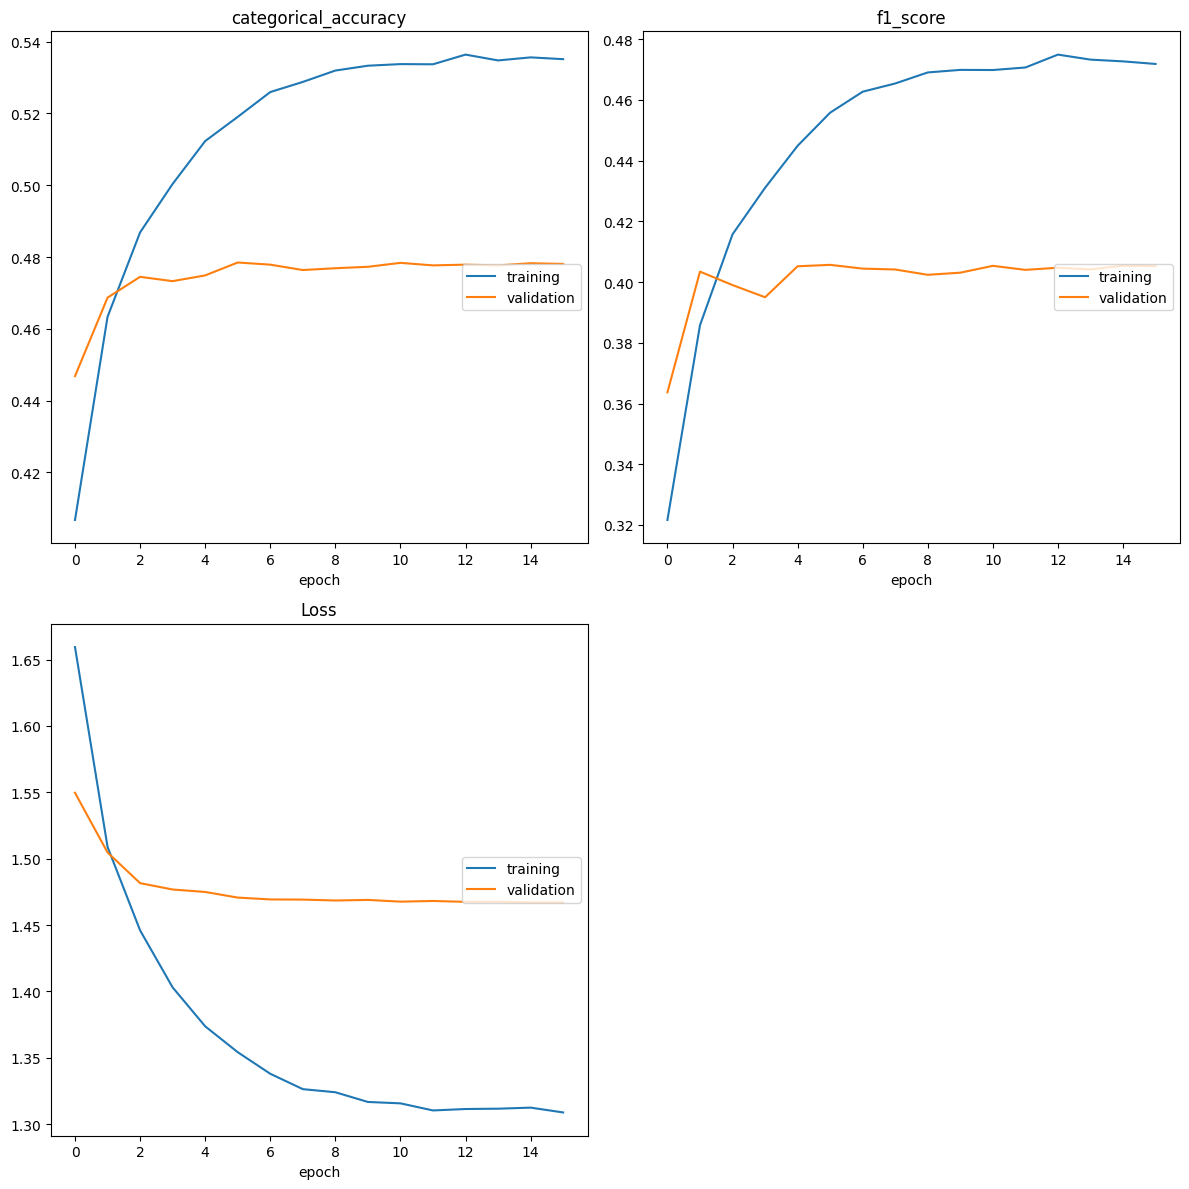

categorical_accuracy
	training         	 (min:    0.407, max:    0.536, cur:    0.535)
	validation       	 (min:    0.447, max:    0.478, cur:    0.478)
f1_score
	training         	 (min:    0.322, max:    0.475, cur:    0.472)
	validation       	 (min:    0.364, max:    0.406, cur:    0.405)
Loss
	training         	 (min:    1.309, max:    1.659, cur:    1.309)
	validation       	 (min:    1.467, max:    1.550, cur:    1.467)
385/385 [==============================] - 861s 2s/step - loss: 1.3088 - categorical_accuracy: 0.5351 - f1_score: 0.4719 - val_loss: 1.4670 - val_categorical_accuracy: 0.4781 - val_f1_score: 0.4053
Epoch 16: early stopping


In [ ]:
EPOCHS = 50
history = transf_learn_model.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[es, checkpoint, PlotLossesCallback()])

In [20]:
transf_learn_model = load_model(os.path.join(os.getcwd(),'CPT', 'ordered_model', '06_checkpoint_0.478'))

In [ ]:
ITER = 200

absolut_mean_times, absolut_median_times = show_inference_time_plots(transf_learn_model, ITER, test_df, IMAGE_SIZE)

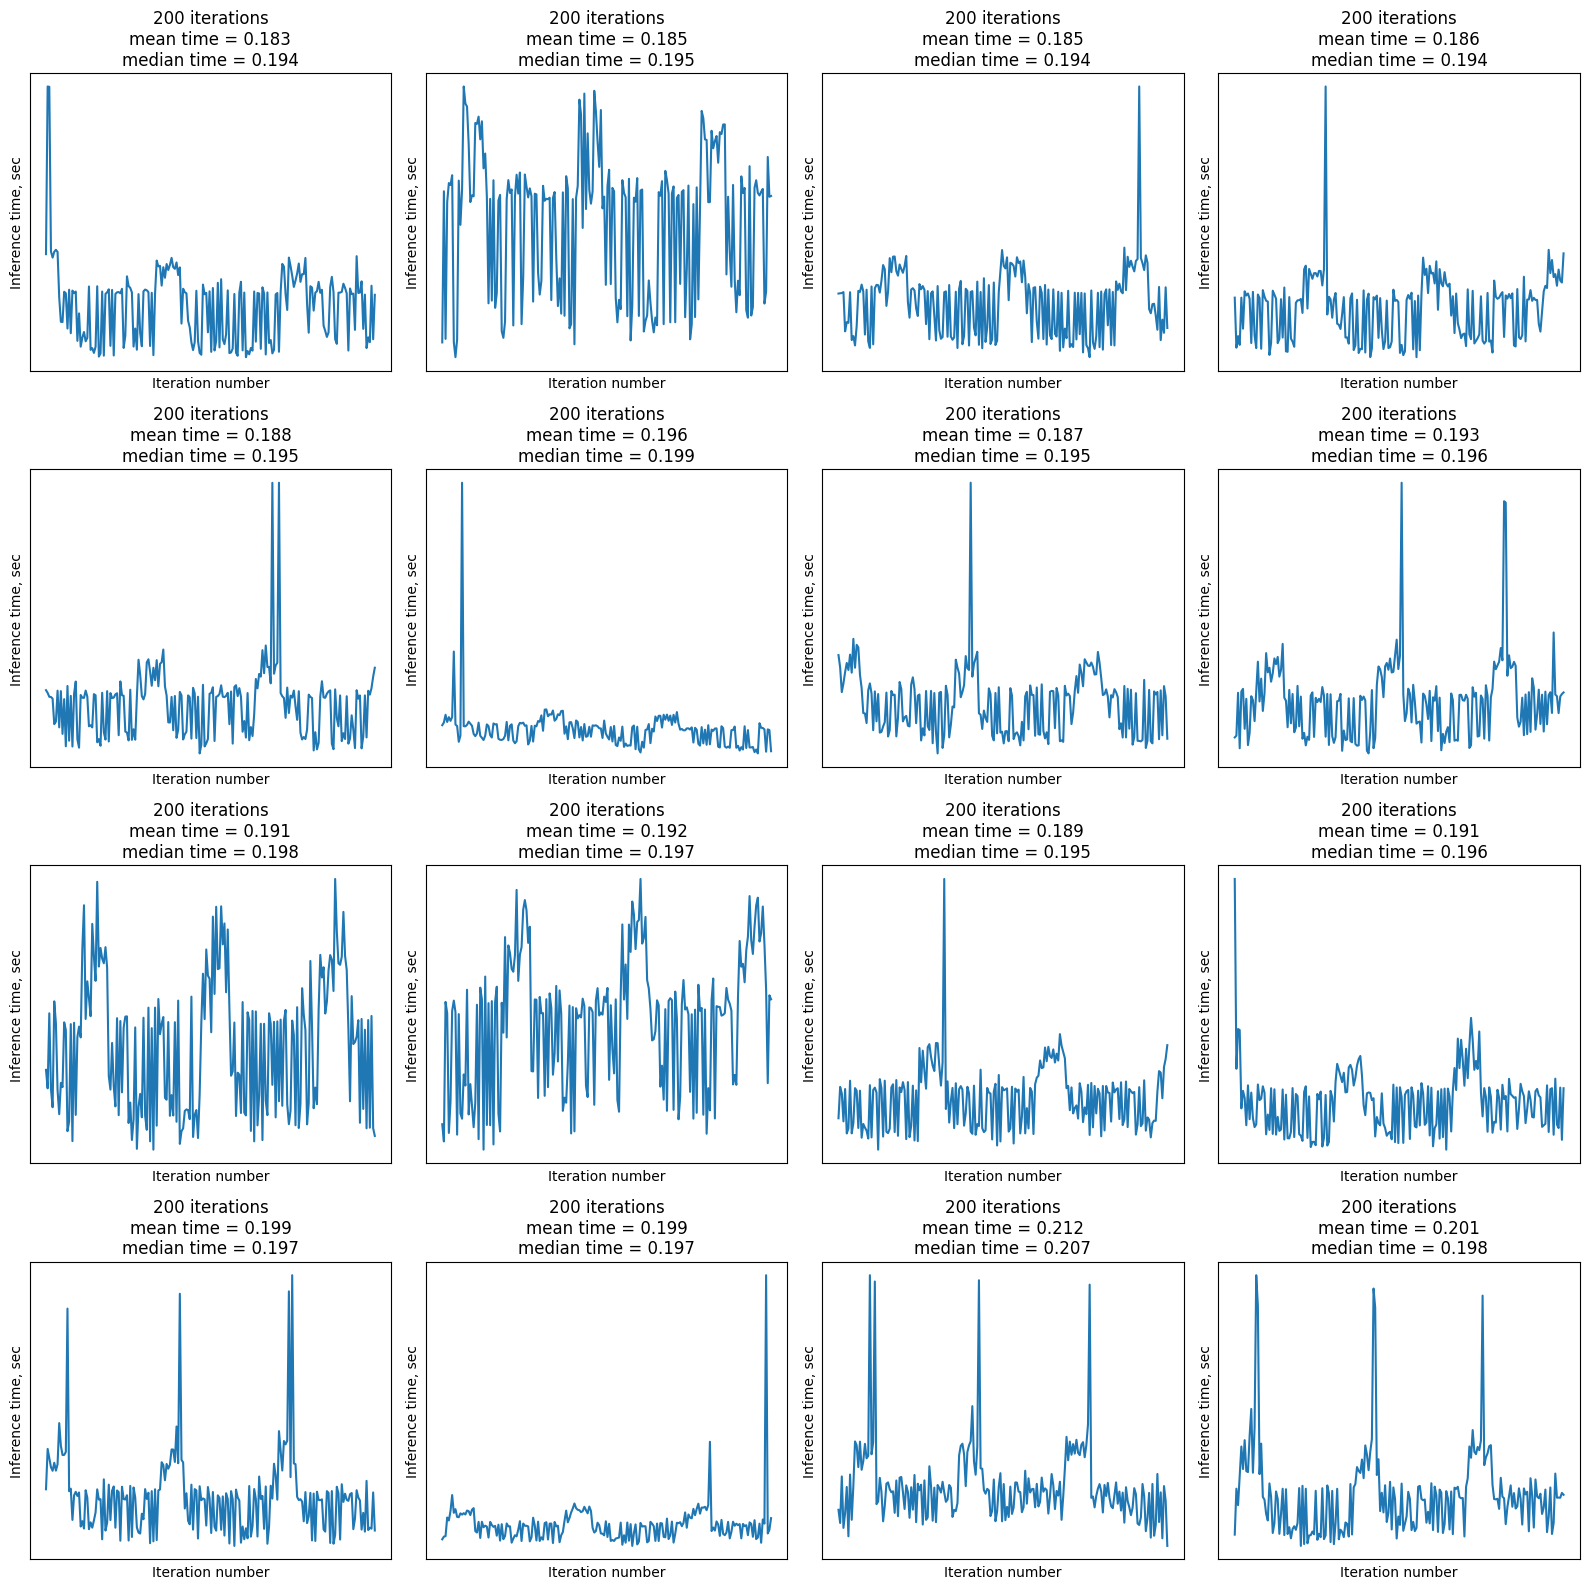

In [23]:
print(np.mean(absolut_mean_times), np.mean(absolut_median_times))

0.19235235720872879 0.1967017948627472


In [ ]:
loss, acc, _ = transf_learn_model.evaluate(val_data_gen, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

97/97 - 180s - loss: 1.4670 - categorical_accuracy: 0.4781 - f1_score: 0.4053 - 180s/epoch - 2s/step
Restored model, accuracy: 47.81%


4/4 [==============================] - 2s 443ms/step


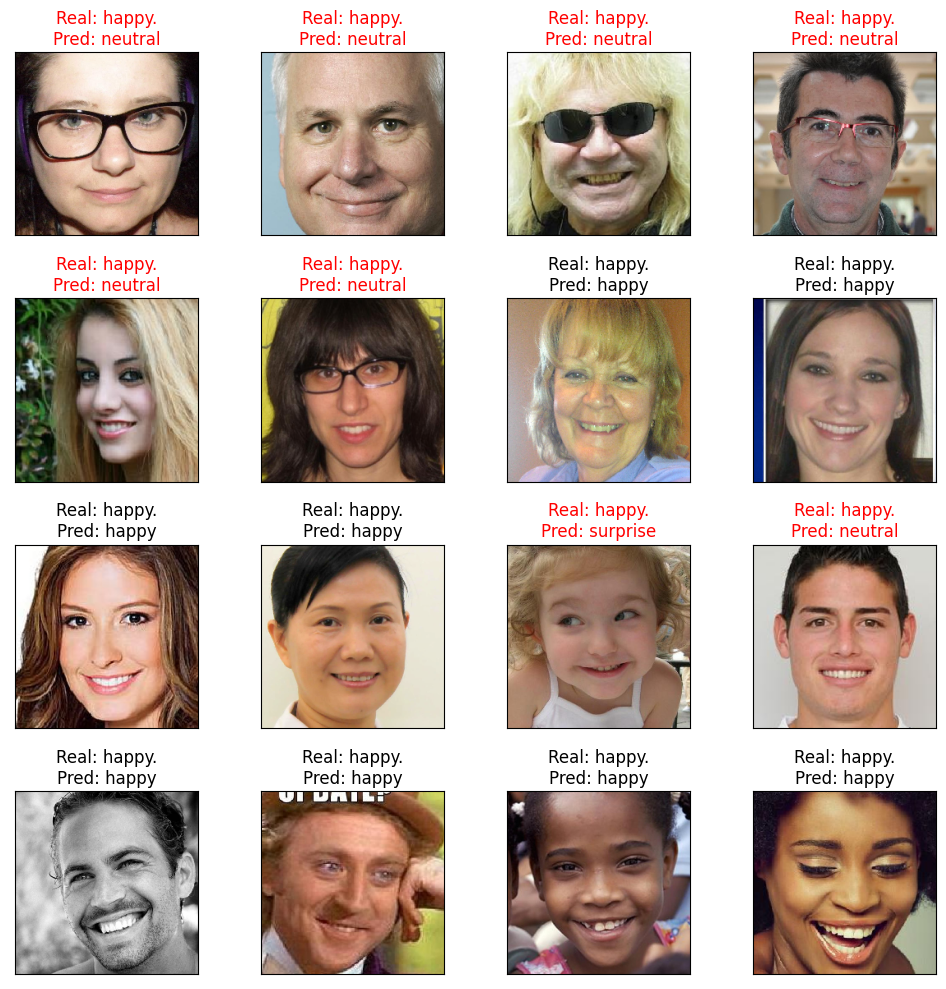

In [ ]:
sample_val_images, sample_val_labels = next(val_data_gen)
show_faces(normalize_0_1(sample_val_images), np.argmax(sample_val_labels, axis = 1), np.argmax(transf_learn_model.predict(sample_val_images), axis=1))

In [ ]:
answer_df = pd.read_csv('sample_submission.csv')
answer_df['emotion'] = test_df['image_path'].apply(lambda x: one_emotion_predict(transf_learn_model, x, IMAGE_SIZE))
answer_df['emotion'] = answer_df['emotion'].apply(lambda x: names[x])

./test_kaggle/0.jpg
1/1 [==============================] - 4s 4s/step
./test_kaggle/1.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/2.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/3.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/4.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/5.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/6.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/7.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/8.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/9.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/10.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/11.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/12.jpg
1/1 [==============================] - 0s 49ms/step
./test_kaggle/13.jpg
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 53ms/step
./test_kaggle/113.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/114.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/115.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/116.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/117.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/118.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/119.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/120.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/121.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/122.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/123.jpg
1/1 [==============================] - 0s 57ms/step
./test_kaggle/124.jpg
1/1 [==============================] - 0s 56ms/step
./test_kaggle/125.jpg
1/1 [==============================] -

1/1 [==============================] - 0s 50ms/step
./test_kaggle/334.jpg
1/1 [==============================] - 0s 49ms/step
./test_kaggle/335.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/336.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/337.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/338.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/339.jpg
1/1 [==============================] - 0s 58ms/step
./test_kaggle/340.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/341.jpg
1/1 [==============================] - 0s 49ms/step
./test_kaggle/342.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/343.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/344.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/345.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/346.jpg
1/1 [==============================] -

1/1 [==============================] - 0s 51ms/step
./test_kaggle/555.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/556.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/557.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/558.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/559.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/560.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/561.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/562.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/563.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/564.jpg
1/1 [==============================] - 0s 56ms/step
./test_kaggle/565.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/566.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/567.jpg
1/1 [==============================] -

1/1 [==============================] - 0s 50ms/step
./test_kaggle/666.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/667.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/668.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/669.jpg
1/1 [==============================] - 0s 48ms/step
./test_kaggle/670.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/671.jpg
1/1 [==============================] - 0s 49ms/step
./test_kaggle/672.jpg
1/1 [==============================] - 0s 48ms/step
./test_kaggle/673.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/674.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/675.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/676.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/677.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/678.jpg
1/1 [==============================] -

1/1 [==============================] - 0s 50ms/step
./test_kaggle/777.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/778.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/779.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/780.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/781.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/782.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/783.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/784.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/785.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/786.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/787.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/788.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/789.jpg
1/1 [==============================] -

1/1 [==============================] - 0s 51ms/step
./test_kaggle/888.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/889.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/890.jpg
1/1 [==============================] - 0s 49ms/step
./test_kaggle/891.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/892.jpg
1/1 [==============================] - 0s 49ms/step
./test_kaggle/893.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/894.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/895.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/896.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/897.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/898.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/899.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/900.jpg
1/1 [==============================] -

1/1 [==============================] - 0s 51ms/step
./test_kaggle/999.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/1000.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/1001.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/1002.jpg
1/1 [==============================] - 0s 49ms/step
./test_kaggle/1003.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/1004.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/1005.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/1006.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/1007.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/1008.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/1009.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/1010.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/1011.jpg
1/1 [=====================

1/1 [==============================] - 0s 50ms/step
./test_kaggle/1217.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/1218.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/1219.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/1220.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/1221.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/1222.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/1223.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/1224.jpg
1/1 [==============================] - 0s 48ms/step
./test_kaggle/1225.jpg
1/1 [==============================] - 0s 49ms/step
./test_kaggle/1226.jpg
1/1 [==============================] - 0s 49ms/step
./test_kaggle/1227.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/1228.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/1229.jpg
1/1 [====================

1/1 [==============================] - 0s 51ms/step
./test_kaggle/1435.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/1436.jpg
1/1 [==============================] - 0s 56ms/step
./test_kaggle/1437.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/1438.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/1439.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/1440.jpg
1/1 [==============================] - 0s 57ms/step
./test_kaggle/1441.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/1442.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/1443.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/1444.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/1445.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/1446.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/1447.jpg
1/1 [====================

1/1 [==============================] - 0s 51ms/step
./test_kaggle/1653.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/1654.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/1655.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/1656.jpg
1/1 [==============================] - 0s 58ms/step
./test_kaggle/1657.jpg
1/1 [==============================] - 0s 49ms/step
./test_kaggle/1658.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/1659.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/1660.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/1661.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/1662.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/1663.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/1664.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/1665.jpg
1/1 [====================

1/1 [==============================] - 0s 51ms/step
./test_kaggle/1871.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/1872.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/1873.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/1874.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/1875.jpg
1/1 [==============================] - 0s 56ms/step
./test_kaggle/1876.jpg
1/1 [==============================] - 0s 49ms/step
./test_kaggle/1877.jpg
1/1 [==============================] - 0s 49ms/step
./test_kaggle/1878.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/1879.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/1880.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/1881.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/1882.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/1883.jpg
1/1 [====================

1/1 [==============================] - 0s 53ms/step
./test_kaggle/2089.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/2090.jpg
1/1 [==============================] - 0s 51ms/step
./test_kaggle/2091.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/2092.jpg
1/1 [==============================] - 0s 49ms/step
./test_kaggle/2093.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/2094.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/2095.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/2096.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/2097.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/2098.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/2099.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/2100.jpg
1/1 [==============================] - 0s 50ms/step
./test_kaggle/2101.jpg
1/1 [====================

1/1 [==============================] - 0s 55ms/step
./test_kaggle/2307.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/2308.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/2309.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/2310.jpg
1/1 [==============================] - 0s 57ms/step
./test_kaggle/2311.jpg
1/1 [==============================] - 0s 71ms/step
./test_kaggle/2312.jpg
1/1 [==============================] - 0s 65ms/step
./test_kaggle/2313.jpg
1/1 [==============================] - 0s 59ms/step
./test_kaggle/2314.jpg
1/1 [==============================] - 0s 56ms/step
./test_kaggle/2315.jpg
1/1 [==============================] - 0s 57ms/step
./test_kaggle/2316.jpg
1/1 [==============================] - 0s 59ms/step
./test_kaggle/2317.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/2318.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/2319.jpg
1/1 [====================

1/1 [==============================] - 0s 53ms/step
./test_kaggle/2525.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/2526.jpg
1/1 [==============================] - 0s 56ms/step
./test_kaggle/2527.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/2528.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/2529.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/2530.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/2531.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/2532.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/2533.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/2534.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/2535.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/2536.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/2537.jpg
1/1 [====================

1/1 [==============================] - 0s 55ms/step
./test_kaggle/2743.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/2744.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/2745.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/2746.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/2747.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/2748.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/2749.jpg
1/1 [==============================] - 0s 57ms/step
./test_kaggle/2750.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/2751.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/2752.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/2753.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/2754.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/2755.jpg
1/1 [====================

1/1 [==============================] - 0s 56ms/step
./test_kaggle/2961.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/2962.jpg
1/1 [==============================] - 0s 56ms/step
./test_kaggle/2963.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/2964.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/2965.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/2966.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/2967.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/2968.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/2969.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/2970.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/2971.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/2972.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/2973.jpg
1/1 [====================

1/1 [==============================] - 0s 56ms/step
./test_kaggle/3179.jpg
1/1 [==============================] - 0s 60ms/step
./test_kaggle/3180.jpg
1/1 [==============================] - 0s 56ms/step
./test_kaggle/3181.jpg
1/1 [==============================] - 0s 56ms/step
./test_kaggle/3182.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/3183.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/3184.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/3185.jpg
1/1 [==============================] - 0s 56ms/step
./test_kaggle/3186.jpg
1/1 [==============================] - 0s 56ms/step
./test_kaggle/3187.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/3188.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/3189.jpg
1/1 [==============================] - 0s 59ms/step
./test_kaggle/3190.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/3191.jpg
1/1 [====================

1/1 [==============================] - 0s 53ms/step
./test_kaggle/3397.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/3398.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/3399.jpg
1/1 [==============================] - 0s 56ms/step
./test_kaggle/3400.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/3401.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/3402.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/3403.jpg
1/1 [==============================] - 0s 56ms/step
./test_kaggle/3404.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/3405.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/3406.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/3407.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/3408.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/3409.jpg
1/1 [====================

1/1 [==============================] - 0s 54ms/step
./test_kaggle/3615.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/3616.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/3617.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/3618.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/3619.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/3620.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/3621.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/3622.jpg
1/1 [==============================] - 0s 59ms/step
./test_kaggle/3623.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/3624.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/3625.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/3626.jpg
1/1 [==============================] - 0s 62ms/step
./test_kaggle/3627.jpg
1/1 [====================

1/1 [==============================] - 0s 53ms/step
./test_kaggle/3833.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/3834.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/3835.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/3836.jpg
1/1 [==============================] - 0s 58ms/step
./test_kaggle/3837.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/3838.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/3839.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/3840.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/3841.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/3842.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/3843.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/3844.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/3845.jpg
1/1 [====================

1/1 [==============================] - 0s 59ms/step
./test_kaggle/4051.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/4052.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/4053.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/4054.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/4055.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/4056.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/4057.jpg
1/1 [==============================] - 0s 59ms/step
./test_kaggle/4058.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/4059.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/4060.jpg
1/1 [==============================] - 0s 56ms/step
./test_kaggle/4061.jpg
1/1 [==============================] - 0s 58ms/step
./test_kaggle/4062.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/4063.jpg
1/1 [====================

1/1 [==============================] - 0s 53ms/step
./test_kaggle/4269.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/4270.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/4271.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/4272.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/4273.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/4274.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/4275.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/4276.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/4277.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/4278.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/4279.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/4280.jpg
1/1 [==============================] - 0s 57ms/step
./test_kaggle/4281.jpg
1/1 [====================

1/1 [==============================] - 0s 55ms/step
./test_kaggle/4487.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/4488.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/4489.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/4490.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/4491.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/4492.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/4493.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/4494.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/4495.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/4496.jpg
1/1 [==============================] - 0s 58ms/step
./test_kaggle/4497.jpg
1/1 [==============================] - 0s 58ms/step
./test_kaggle/4498.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/4499.jpg
1/1 [====================

1/1 [==============================] - 0s 57ms/step
./test_kaggle/4705.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/4706.jpg
1/1 [==============================] - 0s 56ms/step
./test_kaggle/4707.jpg
1/1 [==============================] - 0s 57ms/step
./test_kaggle/4708.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/4709.jpg
1/1 [==============================] - 0s 58ms/step
./test_kaggle/4710.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/4711.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/4712.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/4713.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/4714.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/4715.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/4716.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/4717.jpg
1/1 [====================

1/1 [==============================] - 0s 53ms/step
./test_kaggle/4923.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/4924.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/4925.jpg
1/1 [==============================] - 0s 58ms/step
./test_kaggle/4926.jpg
1/1 [==============================] - 0s 54ms/step
./test_kaggle/4927.jpg
1/1 [==============================] - 0s 58ms/step
./test_kaggle/4928.jpg
1/1 [==============================] - 0s 56ms/step
./test_kaggle/4929.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/4930.jpg
1/1 [==============================] - 0s 55ms/step
./test_kaggle/4931.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/4932.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/4933.jpg
1/1 [==============================] - 0s 52ms/step
./test_kaggle/4934.jpg
1/1 [==============================] - 0s 53ms/step
./test_kaggle/4935.jpg
1/1 [====================

In [ ]:
answer_df

image_path    emotion
0         0.jpg        sad
1         1.jpg    neutral
2         2.jpg    neutral
3         3.jpg  uncertain
4         4.jpg    neutral
...         ...        ...
4995   4995.jpg   surprise
4996   4996.jpg    neutral
4997   4997.jpg    neutral
4998   4998.jpg    neutral
4999   4999.jpg    neutral

[5000 rows x 2 columns]

In [ ]:
answer_df.to_csv('answer.csv', index = False)

**На private kaggle получаем 0.406.** 

# Вывод:

**Этот эксперимент наглядно показал то, что мы уже предполагали в прошлом эксперименте - реальное улучшение датасета за счет правильной сортировки фотографий по эмоциям не приводит к улучшению результата на kaggle, а даже наоборот. Точность ухудшилась. Это говорит о том, что на kaggle датасет также "зашумлён", как и данный нам для обучения. И улучшая исходный датасет, мы повышаем реальную точность определения эмоции, но теряем точность на kaggle.**